In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split
import torch
import seaborn as sns
from tqdm import tqdm

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

In [2]:
random_state = 2016

In [117]:
from tensorflow import keras
# Load the CIFAR-10 dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(-1, 28*28)
test_images = test_images.reshape(-1, 28*28)
train_images.shape

(60000, 784)

In [5]:
# binary = ['sex', 'c_charge_degree']
# other = ['age', 'race', 'priors_count', 'length_of_stay']

In [118]:
def select_dataset(x, y, n1, n2):
    mask = np.where((y==n1) | (y==n2))
    return x[mask], y[mask]

train_images, train_labels = select_dataset(train_images, train_labels, 0,1)
test_images, test_labels = select_dataset(train_images, train_labels, 0,1)
# train_labels
set(test_labels)

{0, 1}

In [5]:
train_images.shape

(12665, 784)

In [6]:
# scaler = MinMaxScaler((-1, 1))
# dataset[other] = scaler.fit_transform(dataset[other])
# dataset[binary] = dataset[binary] - 1

In [20]:
# dataset

In [8]:
# data_train, data_test = train_test_split(train_images, train_labels, train_size=0.8, test_size=0.2, random_state=random_state)
# X_train, y_train = data_train[other + binary], data_train['two_year_recid']
# X_test, y_test = data_test[other + binary], data_test['two_year_recid']

## Single Task NAMs Classification

In [12]:
model = NAMClassifier(
            num_epochs=2,
            num_learners=1,
            metric='accuracy',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=1,
            random_state=random_state
        )

from time import perf_counter
print("training")
start = perf_counter()
model.fit(train_images, train_labels)
print(perf_counter()-start)

training


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:28<00:00,  7.56s/it]
                                                                                                                       
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]
Epoch(0):                                                                                                              
                    Training Loss: 56.183 |
Epoch(0):           Validation Loss: 14.118 | ACCURACY: 0.323:   
                    Training Loss: 56.183 |
                    Validation Loss: 14.118 | ACCURACY: 0.323:  5
100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:35<00:00,  8.23s/it]
                                                                                                                       
100%|███████████████████████████████████████████████████████

198.05480769998394


In [13]:
pred = model.predict(test_images)
# sk_metrics.roc_auc_score(test_labels, pred)
np.mean(pred==test_labels)
# model.evaluate(test_images, test_labels)

0.993999210422424

8


(0.0, 28.0, 28.0, 0.0)

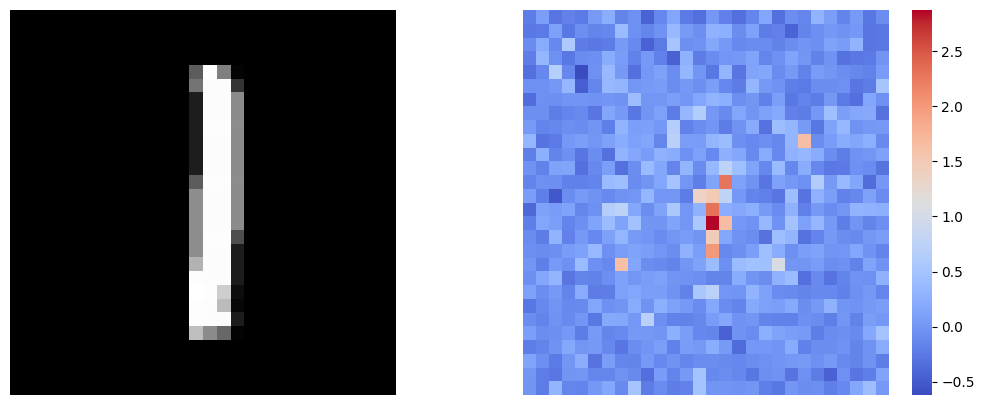

In [196]:
preds = []
idx=155

X = torch.tensor([test_images[idx]], requires_grad=False, dtype=torch.float)
for single_model in model.models:
    print(8)
    preds.append(single_model.calc_outputs(X))

# test_images[0]
image = test_images[idx].reshape(28,28)
image_importance = np.array([x.item() for x in preds[0]]).reshape(28,28)

most_important_idx = np.argmax(np.array([x.item() for x in preds[0]]))

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(13,5))


axs[0].imshow(image, cmap="gray")
sns.heatmap(image_importance, cmap="coolwarm", ax=axs[1])

axs[0].axis("off")
axs[1].axis("off")

In [176]:
small_important_idx = np.argmin(np.array([x.item() for x in preds[0]]))

In [177]:
most_important_idx

434

100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [00:57<00:00,  4.41it/s]


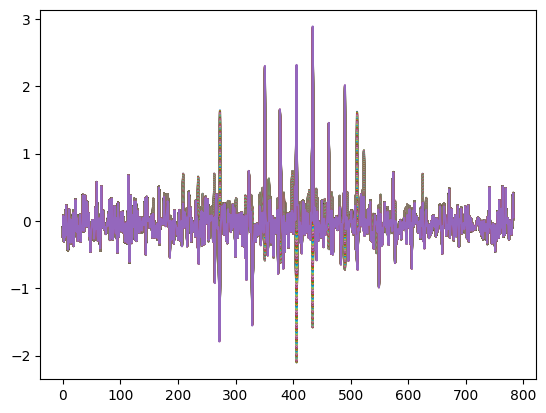

In [178]:
activations = []
test_idx = most_important_idx

test_image = test_images[idx].copy()

for i in tqdm(range(255)):
    i/=255
    test_image[:] = i
#     print(max(test_image))
    X = torch.tensor([test_image], requires_grad=False, dtype=torch.float)
    for single_model in model.models:
        model_out = single_model.calc_outputs(X)
        model_out = np.array([x.item() for x in model_out])
        activations.append(model_out)
        
for activation in activations:
    plt.plot(activation.T)

In [151]:
model.models

[NAM(
   (dropout_layer): Dropout(p=0.05, inplace=False)
   (feature_nns): ModuleList(
     (0): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_features=64, out_features=32)
         (3): Linear(in_features=32, out_features=1, bias=False)
       )
     )
     (1): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_features=64, out_features=32)
         (3): Linear(in_features=32, out_features=1, bias=False)
       )
     )
     (2): FeatureNN(
       (dropout): Dropout(p=0.1, inplace=False)
       (model): ModuleList(
         (0): LinReLU(in_features=1, out_features=2)
         (1): LinReLU(in_features=2, out_features=64)
         (2): LinReLU(in_feat

In [179]:
np.array(activations).shape
activationsT = np.array(activations).T

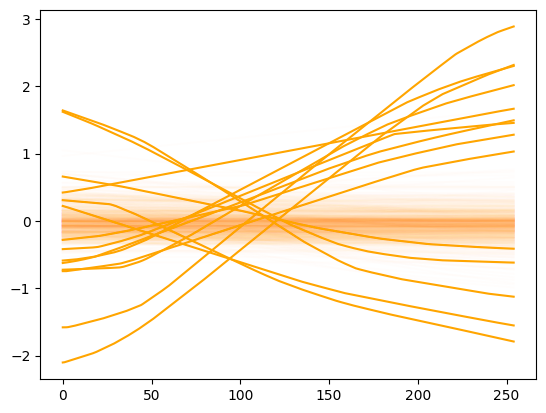

In [195]:
for activation in activationsT:
    if abs(activation[-1]-activation[0])<1:
        plt.plot(activation, alpha=0.01, color="orange")
    else:
        plt.plot(activation, color="orange")

<AxesSubplot: >

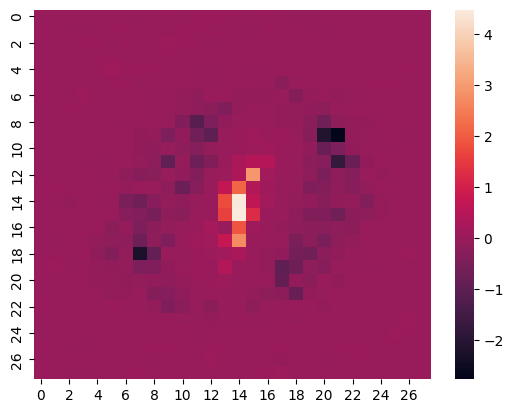

In [72]:
# std = np.std(activationsT,axis=1)
cols = activationsT[:,-1]-activationsT[:,-0]
sns.heatmap(cols.reshape(28,28))
# cols.shape

In [97]:
sorted_imp = np.argsort(cols)

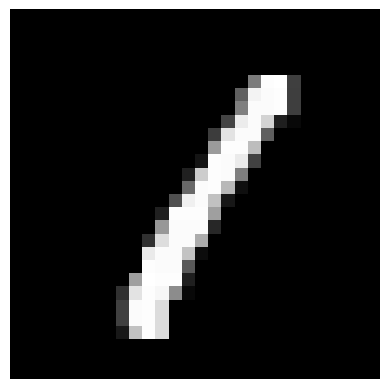

0, 1, 2, 3, 4


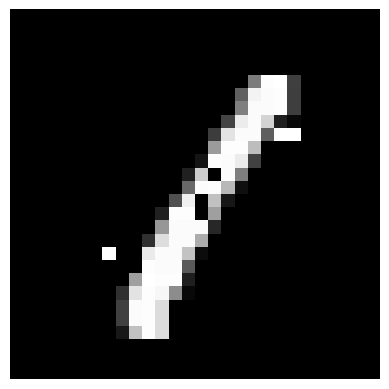

Changed pixels: 6 (0.77%)


In [198]:
test_idx = 1
test_image = test_images[test_idx].copy()
plt.imshow(test_image.reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()

n_px = 0
pred = test_labels[test_idx]
while pred==test_labels[test_idx]:
    for px_idx in sorted_imp[:n_px]:
        test_image[px_idx] = test_labels[test_idx]

    for px_idx in sorted_imp[::-1][:n_px]:
        test_image[px_idx] = 1-test_labels[test_idx]

    pred=model.predict([test_image])
    print(n_px, end=", ")
    n_px+=1


# print(test_labels[test_idx])
print(n_px)
plt.imshow(test_image.reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()
changed_px = np.sum(test_images[test_idx]!=test_image)
print("Changed pixels:", changed_px, f"({changed_px/len(test_image)*100:0.2f}%)")

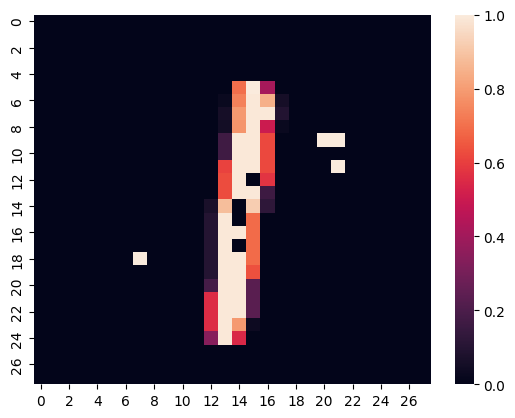

## Multitask NAMs Classification

In [20]:
def make_gender_mtl_data(X, y):
    y_male = y.copy()
    y_male[X['sex'] == 1] = np.nan
    y_female = y.copy()
    y_female[X['sex'] == 0] = np.nan
    return pd.concat([y_female, y_male], axis=1)

In [21]:
y_train_mtl = make_gender_mtl_data(X_train, y_train)
y_test_mtl = make_gender_mtl_data(X_test, y_test)

In [22]:
X_train_mtl = X_train.drop(columns=['sex'])
X_test_mtl = X_test.drop(columns=['sex'])

In [23]:
# NaN indicates label missing
y_train_mtl

,two_year_recid,two_year_recid
4819,0.0,NaN
1581,NaN,1.0
0,0.0,NaN
1575,0.0,NaN
1159,1.0,NaN
...,...,...
4604,0.0,NaN
653,0.0,NaN
4691,0.0,NaN
5386,NaN,1.0


In [24]:
model = MultiTaskNAMClassifier(
            num_learners=1,
            patience=60,
            num_epochs=100,
            num_subnets=1,
            metric='auroc',
            monitor_loss=False,
            early_stop_mode='max',
            n_jobs=1,
            random_state=random_state
        )

start = perf_counter()
print("training")
model.fit(X_train_mtl, y_train_mtl)
print(perf_counter()-start)

training


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 25.92it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(0):                                                                                                              
                    Training Loss: 0.841 |
Epoch(0):           Validation Loss: 0.723 | AUROC: 0.496:   0%| |
                    Training Loss: 0.841 |
                    Validation Loss: 0.723 | AUROC: 0.496:   1%| |
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 24.82it/s]
                                                                                                                       
  0%|                                                       

                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(19):                                                                                                             
                    Training Loss: 0.661 |
Epoch(19):          Validation Loss: 0.652 | AUROC: 0.656:  19%|▏
                    Training Loss: 0.661 |
                    Validation Loss: 0.652 | AUROC: 0.656:  20%|▏
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 25.84it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(20):                                                    

Epoch(38):                                                                                                             
                    Training Loss: 0.650 |
Epoch(38):          Validation Loss: 0.639 | AUROC: 0.663:  38%|▍
                    Training Loss: 0.650 |
                    Validation Loss: 0.639 | AUROC: 0.663:  39%|▍
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.59it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(39):                                                                                                             
                    Training Loss: 0.641 |
Epoch(39):          Validation Loss: 0.637 | AUROC: 0.666:  39%|▍
                    Training Loss: 0.641 |
                    Validation

Epoch(57):          Validation Loss: 0.632 | AUROC: 0.674:  57%|▌
                    Training Loss: 0.647 |
                    Validation Loss: 0.632 | AUROC: 0.674:  58%|▌
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 23.98it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(58):                                                                                                             
                    Training Loss: 0.646 |
Epoch(58):          Validation Loss: 0.638 | AUROC: 0.671:  58%|▌
                    Training Loss: 0.646 |
                    Validation Loss: 0.638 | AUROC: 0.671:  59%|▌
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 19.43it/s]
       

Epoch(76):                                                                                                             
                    Training Loss: 0.650 |
Epoch(76):          Validation Loss: 0.634 | AUROC: 0.679:  76%|▊
                    Training Loss: 0.650 |
                    Validation Loss: 0.634 | AUROC: 0.679:  77%|▊
 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:00<00:00, 18.27it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(77):                                                                                                             
                    Training Loss: 0.639 |
Epoch(77):          Validation Loss: 0.633 | AUROC: 0.673:  77%|▊
                    Training Loss: 0.639 |
                    Validation

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(95):                                                                                                             
                    Training Loss: 0.640 |
Epoch(95):          Validation Loss: 0.625 | AUROC: 0.673:  95%|▉
                    Training Loss: 0.640 |
                    Validation Loss: 0.625 | AUROC: 0.673:  96%|▉
 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 21.95it/s]
                                                                                                                       
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]
Epoch(96):                                                                                                             
                    Training Loss: 0.648 |
Epoch(96):         

24.090321699972264


In [25]:
pred = model.predict_proba(X_test_mtl)

In [26]:
# Flatten and remove nans
y_test_mtl_flat = y_test_mtl.to_numpy().reshape(-1)
pred_flat = pred.reshape(-1)

non_nan_indices = y_test_mtl_flat == y_test_mtl_flat 
y_test_mtl_flat = y_test_mtl_flat[non_nan_indices]
pred_flat = pred_flat[non_nan_indices]

In [27]:
sk_metrics.roc_auc_score(y_test_mtl_flat, pred_flat)

0.6968139883572644